## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os
import requests

import statsmodels.formula.api as smf
from matplotlib.colors import ListedColormap

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_samples, silhouette_score

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

## 2. Load Data

###  2.1 London Borough Data

In [2]:
shp_url = 'https://github.com/parorrr/fsds_group-work/raw/main/data/statistical-gis-boundaries-london/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp'
shx_url = 'https://github.com/parorrr/fsds_group-work/raw/main/data/statistical-gis-boundaries-london/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shx'
dbf_url = 'https://github.com/parorrr/fsds_group-work/raw/main/data/statistical-gis-boundaries-london/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.dbf'
# Add more URLs if there are other necessary files

# Download and save each file
for url in [shp_url, shx_url, dbf_url]:
    r = requests.get(url)
    with open(url.split('/')[-1], 'wb') as f:
        f.write(r.content)

# Now you can read the shapefile
borough = gpd.read_file('London_Borough_Excluding_MHW.shp')  # Use the name of your .shp file
print(borough.head(3))

                   NAME   GSS_CODE  HECTARES  NONLD_AREA ONS_INNER  SUB_2009  \
0  Kingston upon Thames  E09000021  3,726.12        0.00         F       NaN   
1               Croydon  E09000008  8,649.44        0.00         F       NaN   
2               Bromley  E09000006 15,013.49        0.00         F       NaN   

   SUB_2006                                           geometry  
0       NaN  POLYGON ((516401.600 160201.800, 516407.300 16...  
1       NaN  POLYGON ((535009.200 159504.700, 535005.500 15...  
2       NaN  POLYGON ((540373.600 157530.400, 540361.200 15...  


Map it to check

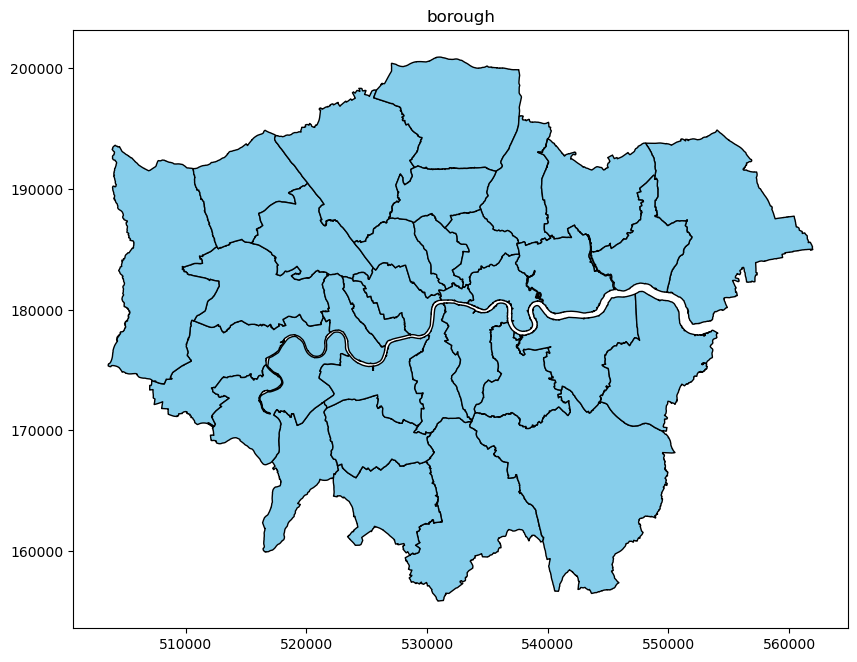

In [3]:
fig, ax = plt.subplots(figsize=(10, 10))
borough.plot(ax=ax, color='skyblue', edgecolor='black')
plt.title('borough')
plt.show()

### 2.2 Airbnb Listing Data

In [4]:
url = 'https://github.com/parorrr/fsds_group-work/raw/main/data/listings.csv.gz'
listings = pd.read_csv(url, compression='gzip', low_memory=False)
print(f"Data frame is {listings.shape[0]:,} x {listings.shape[1]}")

Data frame is 87,946 x 75


In [5]:
print(listings.head(3))

      id                         listing_url       scrape_id last_scraped  \
0  92644  https://www.airbnb.com/rooms/92644  20230906022807   2023-09-06   
1  93015  https://www.airbnb.com/rooms/93015  20230906022807   2023-09-06   
2  13913  https://www.airbnb.com/rooms/13913  20230906022807   2023-09-06   

        source                                               name  \
0  city scrape  Rental unit in Earlsfield · ★4.57 · 1 bedroom ...   
1  city scrape  Rental unit in Hammersmith · ★4.82 · 2 bedroom...   
2  city scrape  Rental unit in Islington · ★4.80 · 1 bedroom ·...   

                                         description  \
0  <b>The space</b><br />Hi everyone! I have 2 ro...   
1  Gorgeous 2 bed ground floor apartment with per...   
2  My bright double bedroom with a large window h...   

                               neighborhood_overview  \
0                                                NaN   
1  A bit of history about the W14 area: <br />Com...   
2  Finsbury Park is a

In [6]:
listings.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87946 entries, 0 to 87945
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            87946 non-null  int64  
 1   listing_url                                   87946 non-null  object 
 2   scrape_id                                     87946 non-null  int64  
 3   last_scraped                                  87946 non-null  object 
 4   source                                        87946 non-null  object 
 5   name                                          87946 non-null  object 
 6   description                                   86679 non-null  object 
 7   neighborhood_overview                         47190 non-null  object 
 8   picture_url                                   87943 non-null  object 
 9   host_id                                       87946 non-null 

In [7]:
listings.head(3)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,92644,https://www.airbnb.com/rooms/92644,20230906022807,2023-09-06,city scrape,Rental unit in Earlsfield · ★4.57 · 1 bedroom ...,<b>The space</b><br />Hi everyone! I have 2 ro...,NaN,https://a0.muscache.com/pictures/715127/85bdb4...,498201,...,4.67,4.53,4.68,NaN,t,1,0,1,0,1.45
1,93015,https://www.airbnb.com/rooms/93015,20230906022807,2023-09-06,city scrape,Rental unit in Hammersmith · ★4.82 · 2 bedroom...,Gorgeous 2 bed ground floor apartment with per...,A bit of history about the W14 area: <br />Com...,https://a0.muscache.com/pictures/865937ec-ee56...,499704,...,4.88,4.85,4.74,NaN,f,1,1,0,0,0.27
2,13913,https://www.airbnb.com/rooms/13913,20230906022807,2023-09-06,city scrape,Rental unit in Islington · ★4.80 · 1 bedroom ·...,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,...,4.82,4.69,4.69,NaN,f,2,1,1,0,0.26


### 2.3 Rents Data

In [8]:
url = 'https://github.com/parorrr/fsds_group-work/raw/main/data/local-authority-rents-borough.csv'
rent = pd.read_csv(url, low_memory=False)
print(f"Data frame is {listings.shape[0]:,} x {listings.shape[1]}")

Data frame is 87,946 x 75


In [9]:
rent.head(3)

,Code,New Code,Area,1996-97,1997-98,1998-99,1999-00,Jan-00,1-Feb,2-Mar,...,2012-13,2013-14,2014-15,2015-16,2016-17,2017-2018,2018-2019,2019-20,2020-21,2021-22
0,00AA,E09000001,City of London,55.34,55.82,56.83,58.58,58.7,60.43,63.12,...,90.16,112.15,100.69,104.73,105.66,104.62,100.51,103.08,106.01,107.87
1,00AB,E09000002,Barking and Dagenham,39.71,42.10,44.43,49.68,52.24,54.52,57.56,...,88.29,90.39,91.99,98.58,.,97.27,94.89,95.52,97.02,96.88
2,00AC,E09000003,Barnet,52.11,52.60,52.59,55.35,56.92,57.78,61.9,...,98.27,98.29,101.05,103.36,102.92,102.75,102.52,101.37,104.61,107.27


In [10]:
rent1 = rent[['New Code', '2021-22']]
rent1.head(3)

,New Code,2021-22
0,E09000001,107.87
1,E09000002,96.88
2,E09000003,107.27


## 3. Clear Listings Data

In [11]:
listings = listings[listings['minimum_nights'] <= 30]

In [12]:
# Select variables of interest
listings = listings[['id','neighbourhood_cleansed','host_listings_count','accommodates','price','availability_365',]]
#check output and datatypes
listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86578 entries, 0 to 87945
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      86578 non-null  int64  
 1   neighbourhood_cleansed  86578 non-null  object 
 2   host_listings_count     86573 non-null  float64
 3   accommodates            86578 non-null  int64  
 4   price                   86578 non-null  object 
 5   availability_365        86578 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB


In [13]:
# 列出所有需要检查的列
columns_to_check = ['neighbourhood_cleansed', 'host_listings_count', 'accommodates', 'price', 'availability_365',]

# 使用字典来存储每列缺失值的数量
missing_values = {col: listings[col].isnull().sum() for col in columns_to_check}

# 打印每列的缺失值数量
for col, num_missing in missing_values.items():
    print(f"Number of missing values in '{col}': {num_missing}")


Number of missing values in 'neighbourhood_cleansed': 0
Number of missing values in 'host_listings_count': 5
Number of missing values in 'accommodates': 0
Number of missing values in 'price': 0
Number of missing values in 'availability_365': 0


In [14]:
# 给定的示例
listings.dropna(subset=['host_listings_count'], inplace=True)

# 如果你还想删除其他列中包含缺失值的行
columns_to_drop_na = ['neighbourhood_cleansed', 'accommodates', 'price', 'availability_365',]
listings.dropna(subset=columns_to_drop_na, inplace=True)


In [15]:
# 列出所有需要检查的列
columns_to_check = ['neighbourhood_cleansed', 'host_listings_count', 'accommodates', 'price', 'availability_365',]

# 使用字典来存储每列缺失值的数量
missing_values = {col: listings[col].isnull().sum() for col in columns_to_check}

# 打印每列的缺失值数量
for col, num_missing in missing_values.items():
    print(f"Number of missing values in '{col}': {num_missing}")

Number of missing values in 'neighbourhood_cleansed': 0
Number of missing values in 'host_listings_count': 0
Number of missing values in 'accommodates': 0
Number of missing values in 'price': 0
Number of missing values in 'availability_365': 0


In [16]:
listings['price'] = listings['price'].astype(str).str.replace(",", "").str.replace("$", "").astype(float)

In [17]:
print(listings)

                       id  neighbourhood_cleansed  host_listings_count  \
0                   92644              Wandsworth                 1.00   
1                   93015  Hammersmith and Fulham                 1.00   
2                   13913               Islington                 3.00   
3                   15400  Kensington and Chelsea                 1.00   
4                   93734               Greenwich                 1.00   
...                   ...                     ...                  ...   
87941  973781286754517228             Westminster                 2.00   
87942  973801695874775338               Southwark                 1.00   
87943  973811685656289740                  Merton                 1.00   
87944  973882998775927897                Hounslow             2,538.00   
87945  973895808066047620          City of London                37.00   

       accommodates  price  availability_365  
0                 2  42.00               217  
1                

In [18]:
listings.to_csv('listings.csv', index=False)

## 4. Group Data per Borough

In [19]:
# Aggregate total availability days per neighbourhood
availability_grouped = listings.groupby('neighbourhood_cleansed')['availability_365'].sum().reset_index()

# Count the number of listings per neighbourhood
listings_count = listings.groupby('neighbourhood_cleansed').size().reset_index(name='listing_count')

# Merge the count with the merged data
availability_grouped = availability_grouped.merge(listings_count, on='neighbourhood_cleansed')

# Calculate the occupancy rate directly
availability_grouped['occupancy_rate'] = (365 - (availability_grouped['availability_365'] / availability_grouped['listing_count'])) / 365

# Viewing the results
print(availability_grouped[['neighbourhood_cleansed', 'occupancy_rate']])

# Exporting to CSV
availability_grouped.to_csv('occupancy_rate.csv', index=False)

    neighbourhood_cleansed  occupancy_rate
0     Barking and Dagenham            0.53
1                   Barnet            0.59
2                   Bexley            0.43
3                    Brent            0.63
4                  Bromley            0.57
5                   Camden            0.68
6           City of London            0.63
7                  Croydon            0.55
8                   Ealing            0.62
9                  Enfield            0.50
10               Greenwich            0.59
11                 Hackney            0.77
12  Hammersmith and Fulham            0.69
13                Haringey            0.70
14                  Harrow            0.53
15                Havering            0.44
16              Hillingdon            0.48
17                Hounslow            0.57
18               Islington            0.75
19  Kensington and Chelsea            0.63
20    Kingston upon Thames            0.66
21                 Lambeth            0.73
22         

In [20]:
# 聚合住房数据
listings_grouped = listings.groupby('neighbourhood_cleansed')['host_listings_count'].sum().reset_index()
# 合并数据
merged_data = borough.merge(listings_grouped, left_on='NAME', right_on='neighbourhood_cleansed')
# 计算住宅密度
# 假设 boroughs DataFrame 有一个名为 'area' 的面积列
merged_data['host_density'] = merged_data['host_listings_count'] / merged_data['HECTARES']
# 查看结果
print(merged_data[['neighbourhood_cleansed', 'host_density']])
# 导出到 CSV
merged_data.to_csv('host_density.csv', index=False)


    neighbourhood_cleansed  host_density
0     Kingston upon Thames          3.54
1                  Croydon          3.53
2                  Bromley          0.55
3                 Hounslow         23.87
4                   Ealing         14.09
5                 Havering          0.98
6               Hillingdon          3.12
7                   Harrow          3.01
8                    Brent         78.94
9                   Barnet         24.12
10                 Lambeth         55.02
11               Southwark         95.36
12                Lewisham          9.77
13               Greenwich         15.17
14                  Bexley          1.82
15                 Enfield          0.95
16          Waltham Forest          5.84
17               Redbridge          4.00
18                  Sutton          2.43
19    Richmond upon Thames          2.78
20                  Merton          7.09
21              Wandsworth         27.74
22  Hammersmith and Fulham         53.57
23  Kensington a

In [21]:
# 聚合住房数据
listings_grouped = listings.groupby('neighbourhood_cleansed')['accommodates'].sum().reset_index()

# Count the number of listings per neighbourhood
listings_count = listings.groupby('neighbourhood_cleansed').size().reset_index(name='listing_count')

# Merge the count with the merged data
listings_grouped = listings_grouped.merge(listings_count, on='neighbourhood_cleansed')

# 计算住宅密度
# 假设 boroughs DataFrame 有一个名为 'area' 的面积列
listings_grouped['average_accommodates'] = listings_grouped['accommodates'] / listings_grouped['listing_count']
# 查看结果
print(listings_grouped[['neighbourhood_cleansed', 'average_accommodates']])
# 导出到 CSV
listings_grouped.to_csv('average_accommodates.csv', index=False)

    neighbourhood_cleansed  average_accommodates
0     Barking and Dagenham                  3.04
1                   Barnet                  3.28
2                   Bexley                  2.88
3                    Brent                  3.10
4                  Bromley                  3.12
5                   Camden                  3.29
6           City of London                  3.02
7                  Croydon                  2.92
8                   Ealing                  3.02
9                  Enfield                  2.96
10               Greenwich                  3.24
11                 Hackney                  2.92
12  Hammersmith and Fulham                  3.29
13                Haringey                  3.12
14                  Harrow                  2.78
15                Havering                  3.38
16              Hillingdon                  2.79
17                Hounslow                  2.88
18               Islington                  3.04
19  Kensington and C

In [22]:
# 聚合住房数据
listings_grouped = listings.groupby('neighbourhood_cleansed')['price'].sum().reset_index()

# Count the number of listings per neighbourhood
listings_count = listings.groupby('neighbourhood_cleansed').size().reset_index(name='listing_count')

# Merge the count with the merged data
listings_grouped = listings_grouped.merge(listings_count, on='neighbourhood_cleansed')

# 计算住宅密度
# 假设 boroughs DataFrame 有一个名为 'area' 的面积列
listings_grouped['average_price'] = listings_grouped['price'] / listings_grouped['listing_count']
# 查看结果
print(listings_grouped[['neighbourhood_cleansed', 'average_price']])
# 导出到 CSV
listings_grouped.to_csv('average_price.csv', index=False)

    neighbourhood_cleansed  average_price
0     Barking and Dagenham         248.39
1                   Barnet         160.79
2                   Bexley          95.27
3                    Brent         179.68
4                  Bromley         106.16
5                   Camden         201.23
6           City of London         244.39
7                  Croydon          91.10
8                   Ealing         125.90
9                  Enfield         107.45
10               Greenwich         122.22
11                 Hackney         130.52
12  Hammersmith and Fulham         177.59
13                Haringey         147.10
14                  Harrow         105.59
15                Havering         118.48
16              Hillingdon         102.84
17                Hounslow         183.41
18               Islington         173.65
19  Kensington and Chelsea         307.71
20    Kingston upon Thames         134.82
21                 Lambeth         141.04
22                Lewisham        

## 5. Combine All the Grouped Data

In [23]:
# 读取所有文件并存储在字典中
files = ['host_density', 'occupancy_rate', 'average_accommodates', 'average_price' ]
dataframes = {file: pd.read_csv(f'{file}.csv', low_memory=False) for file in files}

# 合并所有DataFrame
merged_listings_borough = dataframes['host_density'].drop('neighbourhood_cleansed', axis=1)
for file in files[1:]:
    merged_listings_borough = merged_listings_borough.merge(
        dataframes[file][['neighbourhood_cleansed', file]],
        left_on='NAME',
        right_on='neighbourhood_cleansed'
    )

# 删除所有重复的 'neighbourhood_cleansed' 列
merged_listings_borough = merged_listings_borough.loc[:, ~merged_listings_borough.columns.duplicated()]

# 保存最终的DataFrame
merged_listings_borough.to_csv('merged_listings_borough.csv', index=False)


## 6. Merge Rent Data to listings_borough Data 

In [24]:
listings_borough_rent = merged_listings_borough.merge(rent1, left_on='GSS_CODE', right_on='New Code')
listings_borough_rent.drop('New Code', axis=1, inplace=True)
listings_borough_rent.rename(columns={'2021-22': 'rent'}, inplace=True)

In [25]:
listings_borough_rent.head(3)

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,host_listings_count,host_density,neighbourhood_cleansed_x,occupancy_rate,neighbourhood_cleansed_y,average_accommodates,neighbourhood_cleansed,average_price,rent
0,Kingston upon Thames,E09000021,"3,726.12",0.00,F,NaN,NaN,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...","13,184.00",3.54,Kingston upon Thames,0.66,Kingston upon Thames,3.29,Kingston upon Thames,134.82,118.55
1,Croydon,E09000008,"8,649.44",0.00,F,NaN,NaN,"POLYGON ((535009.2 159504.7, 535005.5 159502, ...","30,567.00",3.53,Croydon,0.55,Croydon,2.92,Croydon,91.10,108.71
2,Bromley,E09000006,"15,013.49",0.00,F,NaN,NaN,"POLYGON ((540373.6 157530.4, 540361.2 157551.9...","8,251.00",0.55,Bromley,0.57,Bromley,3.12,Bromley,106.16,100.00


In [26]:
listings_borough_rent.to_csv('listings_borough_rent.csv', index=False)

## 7. Analysis

### 7.1 Descriptive Analysis of Room Types in Each Borough

#### 7.1.1 Administrative Zoning Map of London

In [27]:
url = 'https://github.com/parorrr/fsds_group-work/raw/main/data/listings.csv.gz'
listings2 = pd.read_csv(url, compression='gzip', low_memory=False)
merged_for_zoning = borough.merge(
        listings2,
        left_on='NAME',
        right_on='neighbourhood_cleansed'
    )

In [28]:
# Calculate the most common room_type for each neighbourhood
room_type_counts = merged_for_zoning.groupby('neighbourhood_cleansed')['room_type'].value_counts().reset_index(name='count')
print(room_type_counts)

    neighbourhood_cleansed        room_type  count
0     Barking and Dagenham     Private room    294
1     Barking and Dagenham  Entire home/apt    265
2     Barking and Dagenham      Shared room      5
3                   Barnet  Entire home/apt   1264
4                   Barnet     Private room    961
..                     ...              ...    ...
111             Wandsworth       Hotel room      4
112            Westminster  Entire home/apt   7729
113            Westminster     Private room   2167
114            Westminster      Shared room     52
115            Westminster       Hotel room     44

[116 rows x 3 columns]


In [29]:
idx = room_type_counts.groupby('neighbourhood_cleansed')['count'].transform('max') == room_type_counts['count']
common_room_types = room_type_counts[idx][['neighbourhood_cleansed', 'room_type']]

In [30]:
# Merge the common room types back into the merged data
borough_for_zoning = borough.merge(common_room_types, left_on='NAME',
        right_on='neighbourhood_cleansed')

In [31]:
# Define colors for room types
room_type_colors = {'Entire home/apt': 'yellow', 'Private room': 'green'}

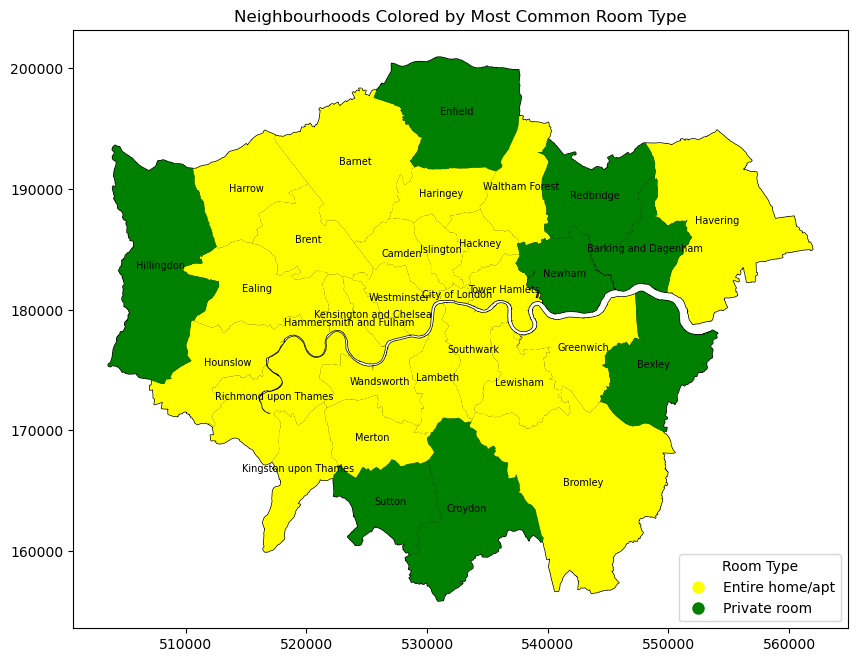

In [32]:
# Plotting the map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the base map (boroughs)
borough.plot(ax=ax, color='lightgrey', edgecolor='black')

# Loop through each neighbourhood, plot its geometry, and color it according to the most common room_type
for idx, row in borough_for_zoning.iterrows():
    color = room_type_colors[row['room_type']]
    borough_for_zoning.iloc[idx:idx + 1].plot(ax=ax, color=color, label=row['room_type'])

    # Add NAME label centered within each polygon
    centroid = borough_for_zoning.geometry.centroid.iloc[idx]
    plt.text(centroid.x, centroid.y, row['NAME'], ha='center', va='center', fontsize=7)

# Set title and legend
plt.title("Neighbourhoods Colored by Most Common Room Type")
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=key, 
                    markerfacecolor=value, markersize=10) for key, value in room_type_colors.items()]
plt.legend(handles=legend_elements, title='Room Type', loc='lower right')

#### 7.1.2 Bar Chart of Room Type in Every Borough

In [33]:
room_type_counts1 = merged_for_zoning.groupby('neighbourhood_cleansed')['room_type'].value_counts().reset_index(name='count')
print(room_type_counts1)

    neighbourhood_cleansed        room_type  count
0     Barking and Dagenham     Private room    294
1     Barking and Dagenham  Entire home/apt    265
2     Barking and Dagenham      Shared room      5
3                   Barnet  Entire home/apt   1264
4                   Barnet     Private room    961
..                     ...              ...    ...
111             Wandsworth       Hotel room      4
112            Westminster  Entire home/apt   7729
113            Westminster     Private room   2167
114            Westminster      Shared room     52
115            Westminster       Hotel room     44

[116 rows x 3 columns]


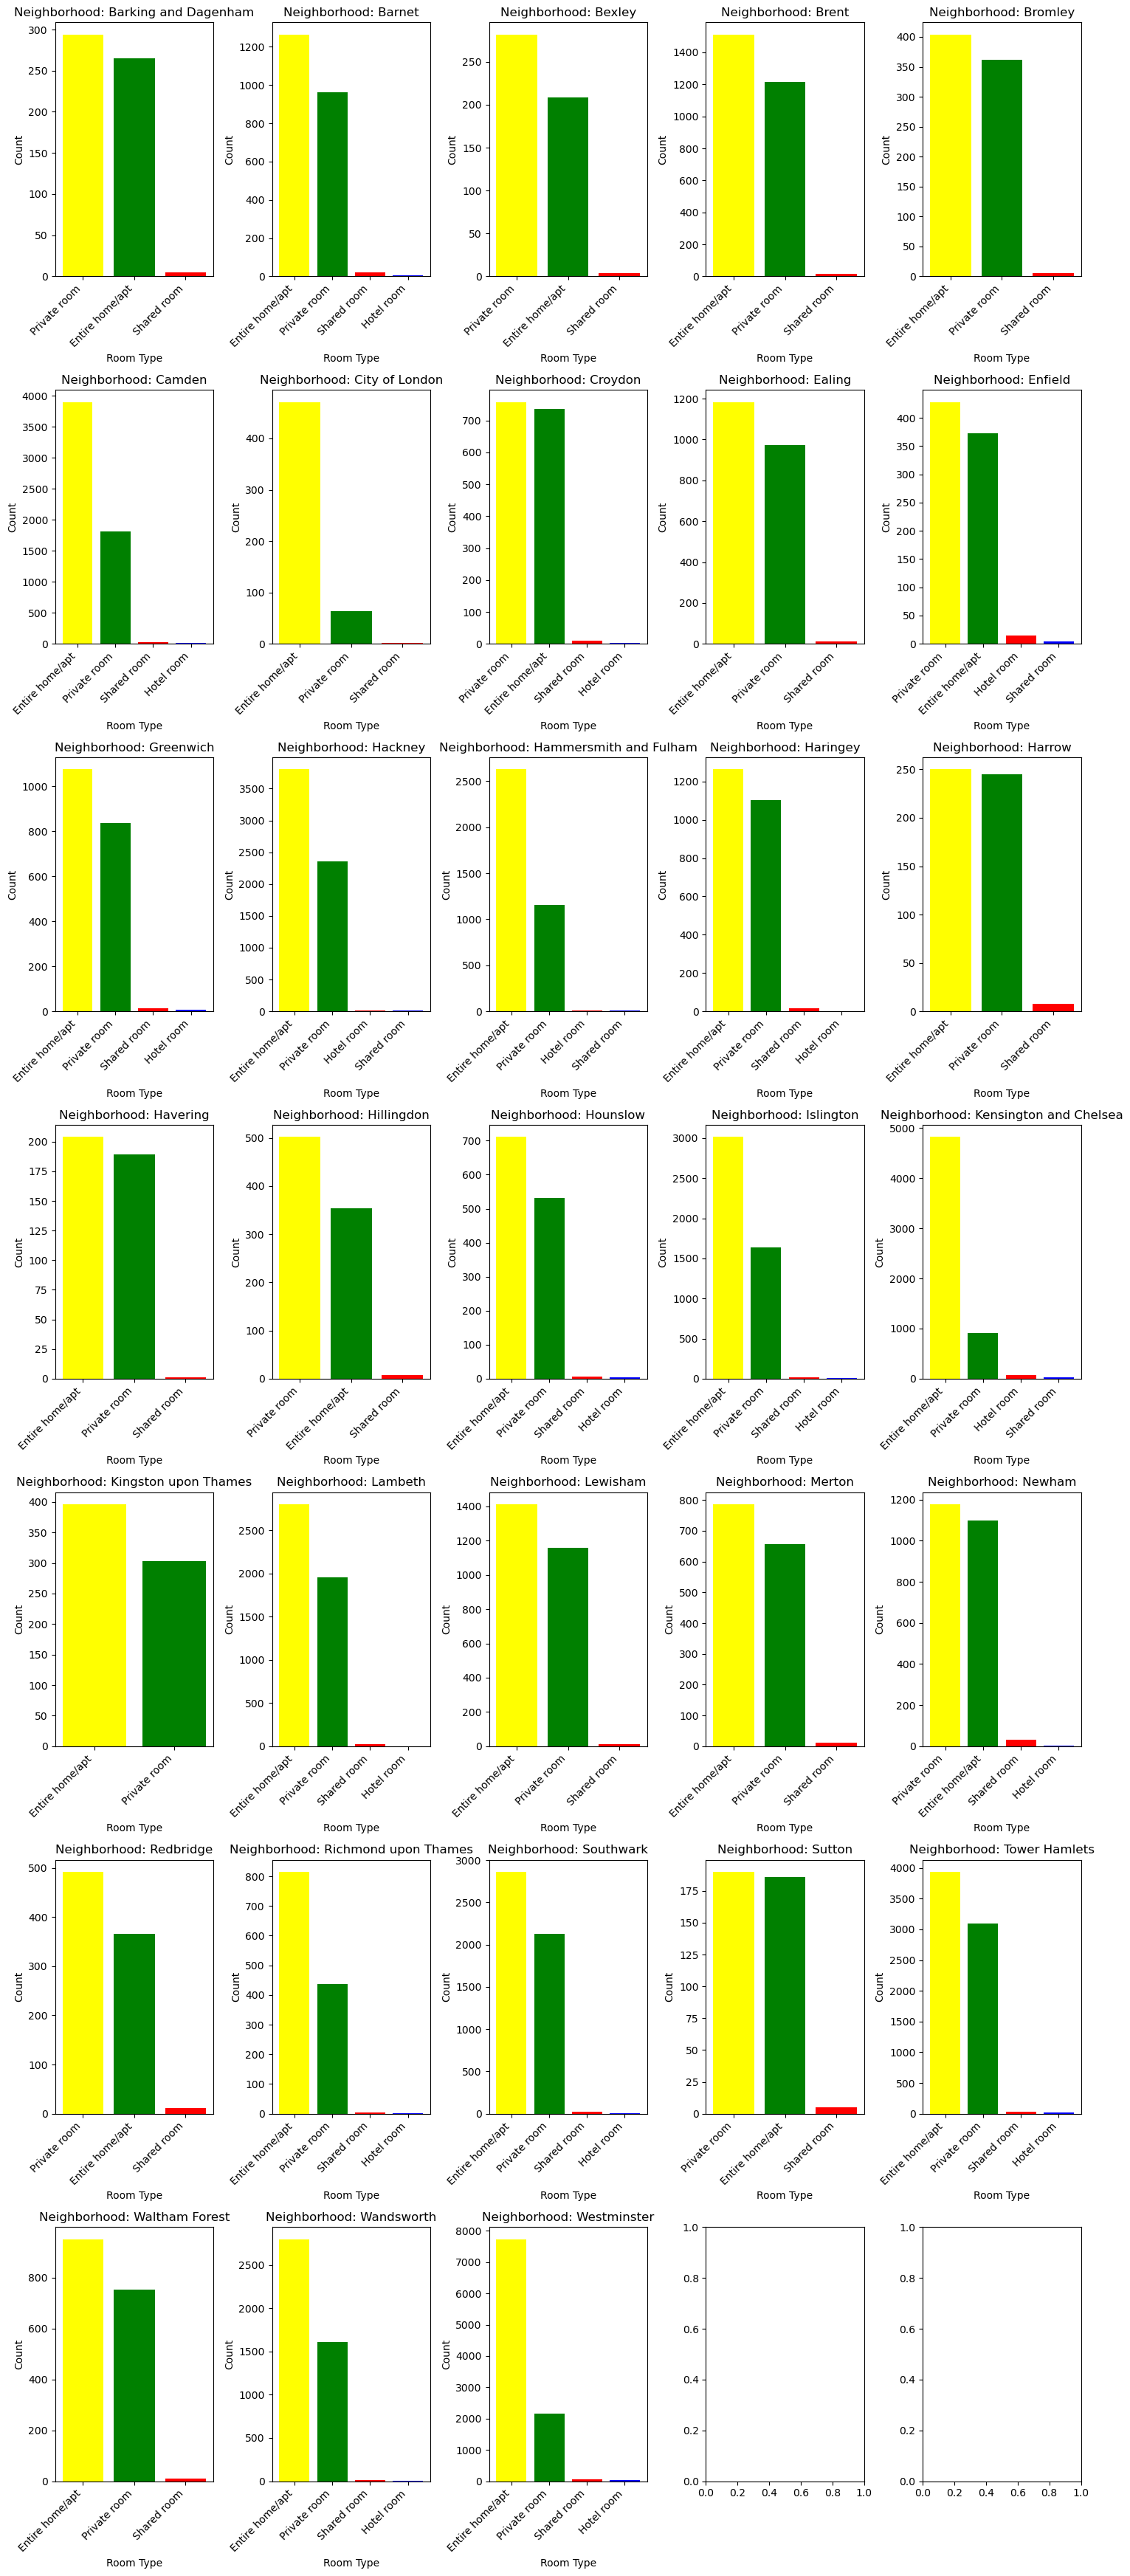

In [34]:
# Get unique neighborhoods
neighborhoods = room_type_counts1['neighbourhood_cleansed'].unique()

# Define the number of rows and columns for subplots
num_plots = len(neighborhoods)
num_rows = num_plots // 5 + (num_plots % 5 > 0)
num_cols = min(num_plots, 5)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

for i, neighborhood in enumerate(neighborhoods):
    row = i // 5
    col = i % 5
    data = room_type_counts1[room_type_counts1['neighbourhood_cleansed'] == neighborhood]
    
    if num_rows > 1:
        ax = axes[row, col]
    else:
        ax = axes[col] if num_plots > 1 else axes
    
    if len(data) > 0:  # Check if there's data for the neighborhood
        x = np.arange(len(data['room_type']))
        ax.bar(x, data['count'], color=['yellow', 'green', 'red','blue'])
        ax.set_xticks(x)
        ax.set_xticklabels(data['room_type'], rotation=45, ha='right')  # Rotate labels for better readability
        ax.set_title(f'Neighborhood: {neighborhood}')
        ax.set_xlabel('Room Type')
        ax.set_ylabel('Count')
    else:
        fig.delaxes(ax)  # Remove empty subplots

# Adjust layout and show plot
plt.tight_layout()
plt.show()

#### 7.1.3 Interpretation

According to the above two charts, the Entire home/apt and Private room are the two most common room types. The most common room type in central London is Entire home/apt, and the most common room type in parts of peripheral London is Private room.

### 7.2 Multiple Linear Regression between Local Rent and independent variables

#### 7.2.1 Checking the Correlation between Variables

In [35]:
df_for_regression = listings_borough_rent[['host_density', 'occupancy_rate', 'average_accommodates', 'average_price', 'rent', ]]
print(df_for_regression.dtypes)

host_density            float64
occupancy_rate          float64
average_accommodates    float64
average_price           float64
rent                    float64
dtype: object


In [36]:
df_for_regression['rent'] = pd.to_numeric(df_for_regression['rent'], errors='coerce')

/tmp/ipykernel_9213/714253410.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_regression['rent'] = pd.to_numeric(df_for_regression['rent'], errors='coerce')


Text(0.5, 1.0, 'Correlation Matrix')

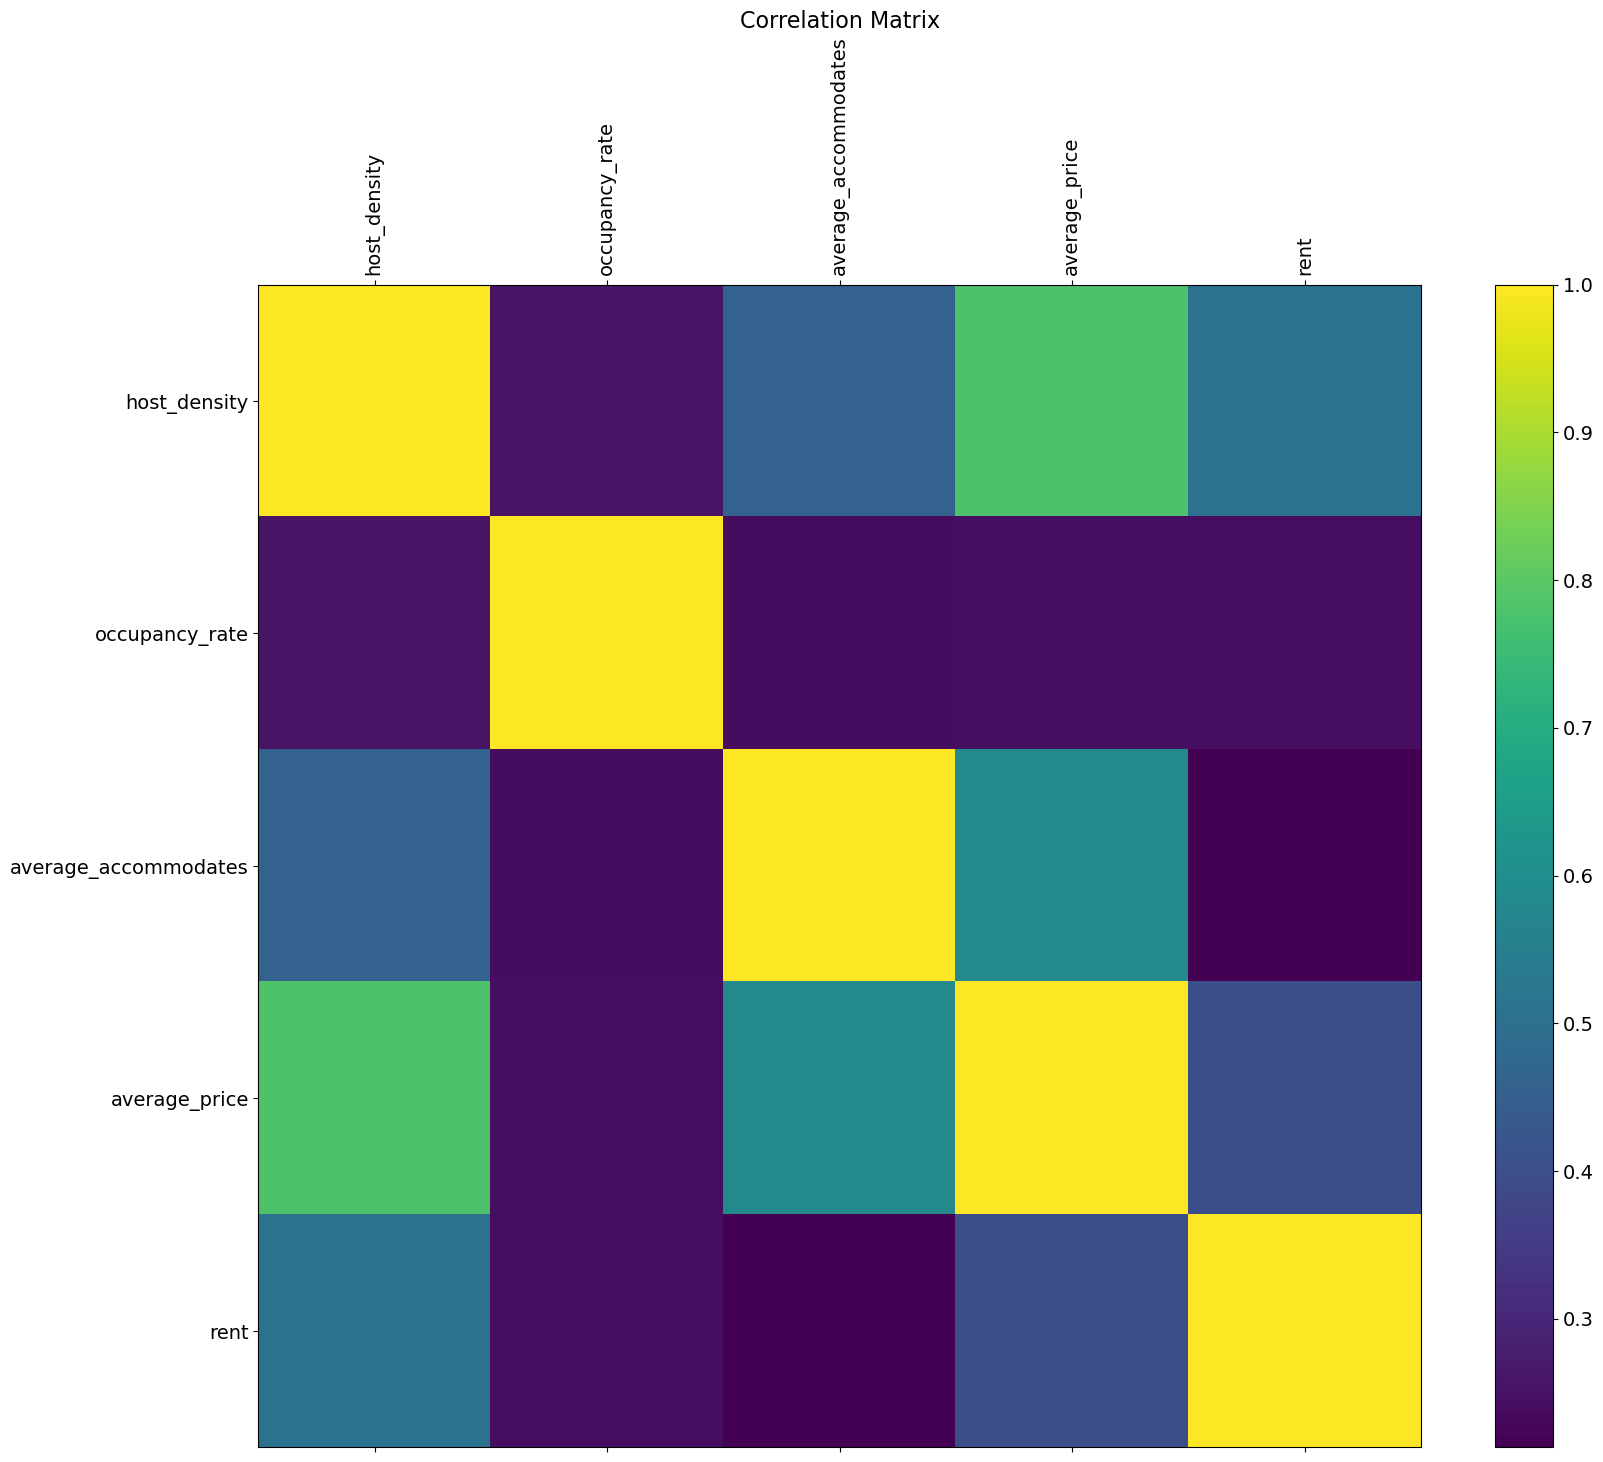

In [37]:
df = df_for_regression
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

#### 7.2.2 Caculate VIF

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def compute_vif(considered_features):
    
    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
        
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

compute_vif(['host_density', 'occupancy_rate', 'average_accommodates', 'average_price'])

,Variable,VIF
0,host_density,2.58
1,occupancy_rate,1.09
2,average_accommodates,1.54
3,average_price,3.05


The variance inflation factor is a statistical measure used to detect multicollinearity, which measures the extent to which each independent variable increases its error due to its correlation with other independent variables. The larger the VIF, the more multicollinearity the corresponding independent variable is affected by in the regression model. Since the VIFs of the above independent variables are less than 5, we will keep all the variables.

#### 7.2.3 Multiple Linear Regression

In [39]:
import statsmodels.api as sm
df = sm.OLS(endog=df[['rent']], exog=sm.add_constant(df[['host_density', 'occupancy_rate', 'average_accommodates', 'average_price']])).fit()
df.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rent   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     2.673
Date:                Mon, 18 Dec 2023   Prob (F-statistic):             0.0526
Time:                        10:23:09   Log-Likelihood:                -113.90
No. Observations:                  33   AIC:                             237.8
Df Residuals:                      28   BIC:                             245.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  105.6165     25.498      4.142      0.000      53.385     157.848
host_density             0.0447      0.024      1.868      0.072      -0.004       0.094
occupancy_rate          12.8671     17.156      0.750      0.460     -22.276      48.010
average_accommodates    -2.3933      8.645     -0.277      0.784     -20.101      15.315
average_price            0.0044      0.044      0.099      0.922      -0.087       0.095
==============================================================================
Omnibus:                        2.376   Durbin-Watson:                   1.485
Prob(Omnibus):                  0.305   Jarque-Bera (JB):                1.769
Skew:                           0.567   Prob(JB):                        0.413
Kurtosis:                       2.958   Cond. No.                     3.49e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 7.2.4 Interpretation

An increase in the density, occupancy, and average price of Airbnb listings, or a decrease in the number of people staying in a single listing, can lead to an increase in local rents.

### 7.3 K-means Clustering

#### 7.3.1 Elbow Method for Optimal k

In [40]:
df_for_cluster = listings_borough_rent[['GSS_CODE', 'host_density', 'occupancy_rate', 'average_accommodates', 'average_price', 'rent']]
df_for_cluster.set_index('GSS_CODE', inplace=True)

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

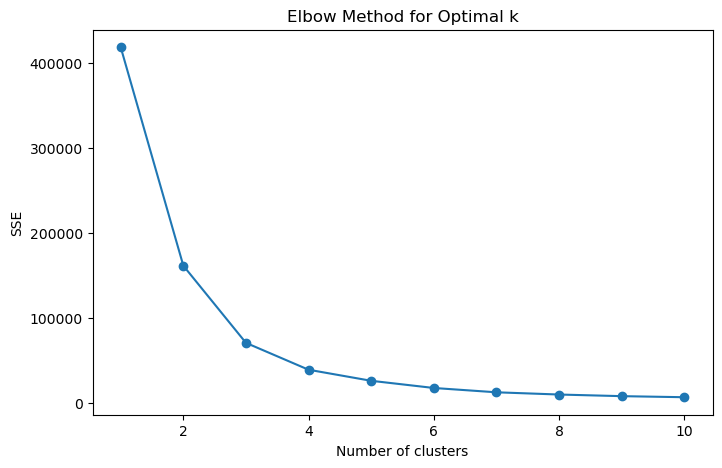

In [41]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 假设你已经有了 DataFrame df_for_cluster

# 选择要用于聚类的特征列
features = ['host_density', 'occupancy_rate', 'average_accommodates', 'average_price', 'rent']
data = df_for_cluster[features]

# 计算不同簇数目下的K均值算法的成本函数值（SSE）
sse = []
for k in range(1, 11):  # 尝试不同的簇数目，这里选择从1到10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    sse.append(kmeans.inertia_)  # inertia_ 属性包含了SSE的值

# 绘制肘部法则曲线
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k')
plt.show()

#### 7.3.2 Clustering

In [42]:
from sklearn.cluster import KMeans

# 假设你有一个包含要用于聚类的特征的 DataFrame：df_for_cluster

# 假设你想要分成4个簇
num_clusters = 4

# 选择特征列
features = ['host_density', 'occupancy_rate', 'average_accommodates', 'average_price', 'rent']
data = df_for_cluster[features]

# 创建KMeans模型并进行拟合
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(data)

# 将每个数据点分配到对应的簇
df_for_cluster['cluster'] = kmeans.labels_

# 查看簇的中心点
cluster_centers = kmeans.cluster_centers_
print("Cluster Centers:")
print(cluster_centers)

# 查看每个簇中的样本数量
cluster_counts = df_for_cluster['cluster'].value_counts()
print("\nCluster Counts:")
print(cluster_counts)

Cluster Centers:
[[163.65083732   0.64697016   3.28728643 251.10785336 116.15      ]
 [  5.06021265   0.56815459   3.03617213 111.80867018 106.00866667]
 [524.7927263    0.63785014   3.55378486 321.5238533  126.76      ]
 [ 50.29815404   0.6750989    3.10328872 166.98052908 110.13785714]]

Cluster Counts:
cluster
1    15
3    14
0     3
2     1
Name: count, dtype: int64


/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_9213/174310726.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_cluster['cluster'] = kmeans.labels_


In [43]:
# Joining with shp file
cluster_shp = pd.merge(borough, df_for_cluster, left_on='GSS_CODE', right_on='GSS_CODE')
cluster_shp.head(3)

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,host_density,occupancy_rate,average_accommodates,average_price,rent,cluster
0,Kingston upon Thames,E09000021,"3,726.12",0.00,F,NaN,NaN,"POLYGON ((516401.600 160201.800, 516407.300 16...",3.54,0.66,3.29,134.82,118.55,1
1,Croydon,E09000008,"8,649.44",0.00,F,NaN,NaN,"POLYGON ((535009.200 159504.700, 535005.500 15...",3.53,0.55,2.92,91.10,108.71,1
2,Bromley,E09000006,"15,013.49",0.00,F,NaN,NaN,"POLYGON ((540373.600 157530.400, 540361.200 15...",0.55,0.57,3.12,106.16,100.00,1


In [44]:
cluster_shp['cluster'] = cluster_shp['cluster'].astype(str)

<Axes: >

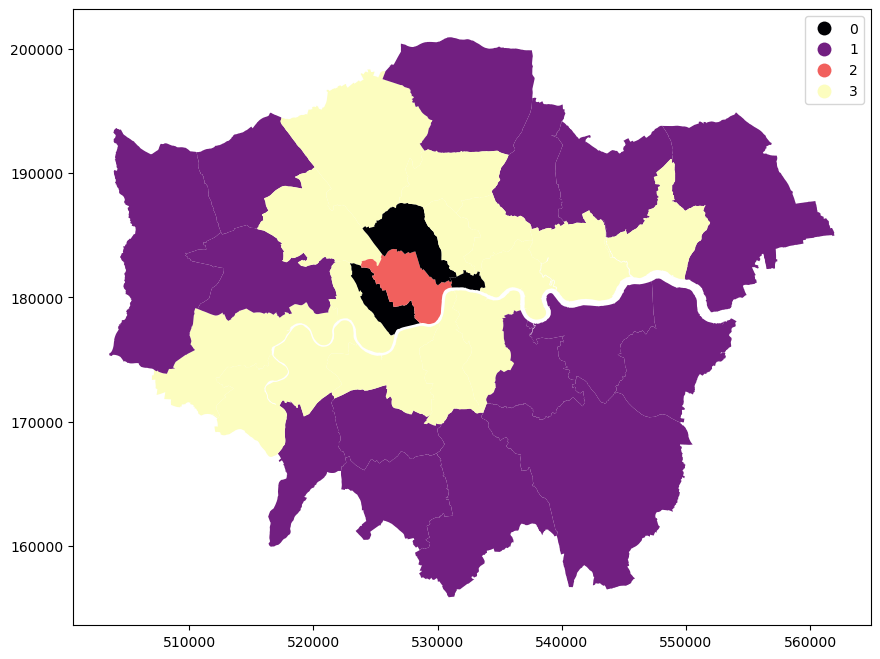

In [45]:
# Plotting
cluster_shp.plot(column='cluster', cmap='magma', edgecolor='none', legend=True, figsize=(12,8))

<Axes: title={'center': 'Cluster comparisions'}, xlabel='cluster'>

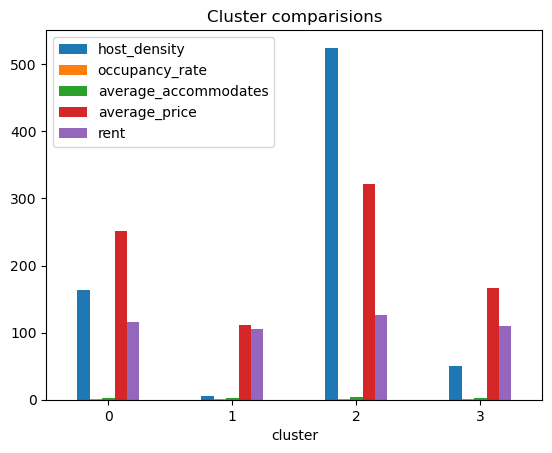

In [46]:
dfcm = df_for_cluster.groupby("cluster").mean()
dfcm.plot.bar(rot=0, title="Cluster comparisions")

#### 7.3.3 Interpretion

The density of Airbnb listings in central London is higher and the average price is higher compared to the London border. Rents are also higher in central London.